In [370]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

load data
align fingerprints
partition building blocks


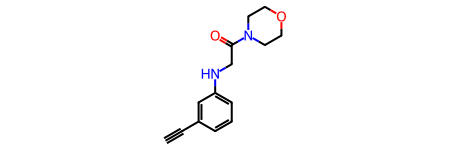

In [367]:
building_blocks['aliphatic_alkyne_robust']['rdMol'][20]

In [2]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create docking oracle
config = {
    'center_x': 9.812,
    'center_y': -0.257,
    'center_z': 20.8485,
    'size_x': 14.328,
    'size_y': 8.85,
    'size_z': 12.539,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'scoring': 'vinardo',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'Mpro affinity',
    receptor_path=f'../../dgym-data/Mpro_prepped.pdbqt',
    config=config
)

In [150]:
generator = library_designer.generate_analogs(deck[8])

# library_designer.enumerate_products(generator, 10)[0]

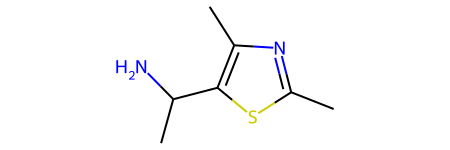

In [374]:
deck[8].reactants[0]

In [311]:
%%time
# molecule = dg.molecule.Molecule(
#     'O=C(c1ccc2c(=O)[nH][nH]c(=O)c2c1)n1nnc2ccccc2c1=O',
#     reactants=['O=C(O)c1ccc2c(=O)[nH][nH]c(=O)c2c1',
#                'O=c1[nH]nnc2ccccc12']
# )

library_designer.reset_cache()
molecules = library_designer.design(
    deck[31],
    size=10,
    mode='analog',
    temperature=0.0
)

CPU times: user 404 ms, sys: 6.21 ms, total: 410 ms
Wall time: 45.1 ms


In [334]:
import chemfp

fingerprint_type = fingerprints.get_fingerprint_type()
fps = [
    (m.id, fingerprint_type.from_smi(m.smiles))
    for m in [deck[31].reactants[1]]
]

queries = chemfp.load_fingerprints(
    fps,
    metadata = fingerprint_type.get_metadata(),
    reorder=False
)

fps_bits = fingerprints.to_numpy_bitarray()
num_in_common = (fps_bits == queries.to_numpy_bitarray()[0]).sum(axis=1)
num_in_common.argsort()[-10:]

array([ 61362,  36475, 232358,  64490,  35306,  35305,  61288, 146823,
        63851, 260085])

In [369]:
building_blocks[35306]

KeyError: 35306

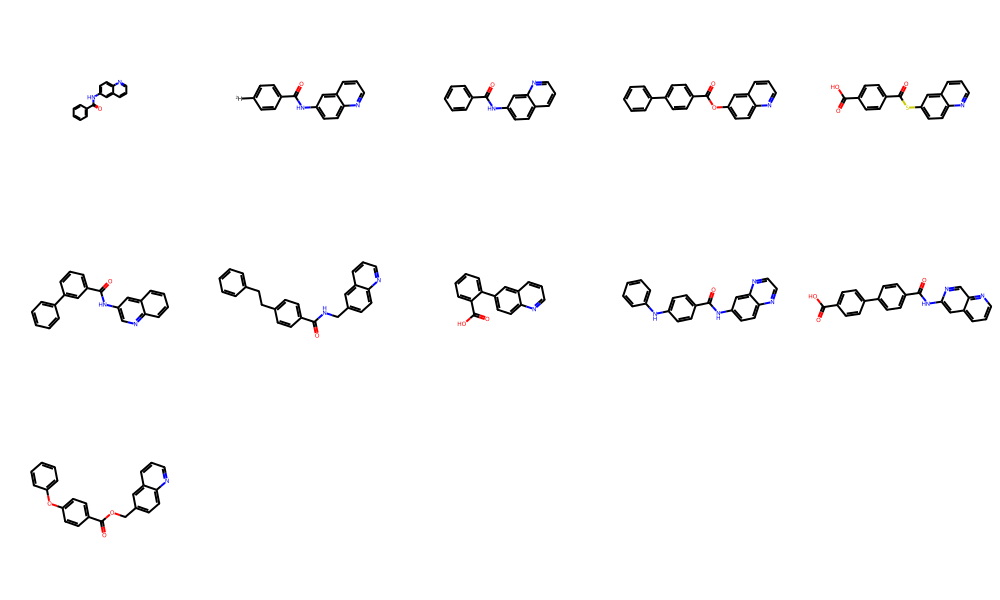

In [312]:
from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage([deck[31].mol, *[p.mol for p in molecules]], molsPerRow=5)

  0%|          | 0/5 [00:00<?, ?it/s]

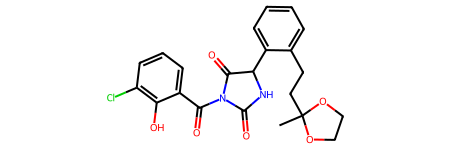

4.187648811909822


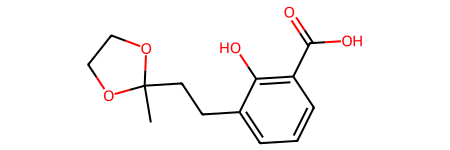

4.47425223998464


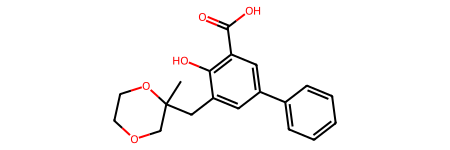

4.603938777273891


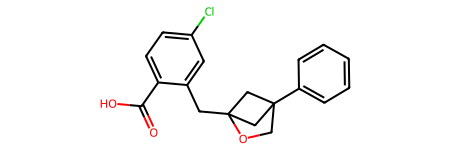

5.036640125791382


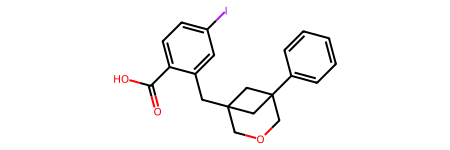

4.9253029732232605


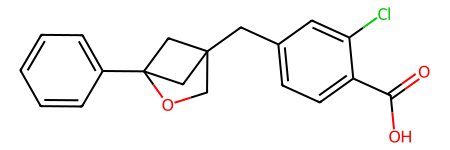

5.2659620819030675


In [546]:
import numpy as np
from tqdm.notebook import tqdm

# best_mol = dg.molecule.Molecule(
#     'O=C(c1ccc2c(=O)[nH][nH]c(=O)c2c1)n1cnc2ccc(F)cc2c1=O',
#     reactants=['O=C(O)c1ccc2c(=O)[nH][nH]c(=O)c2c1',
#                'O=c1[nH]cnc2ccc(F)cc12']
# )
# best_mol = deck[414]
# best_score = docking_oracle([best_mol])

# mols = dg.collection.MoleculeCollection([best_mol])
# all_scores = [best_score]

for _ in tqdm(range(5)):
    
    display(best_mol)
    print(best_score)
    
    analogs = library_designer.design(
        best_mol,
        mode='retrosynthesize',
        temperature=0.3,
        size=10
    )
    mols += analogs

    scores = docking_oracle(analogs)
    all_scores.extend(scores)
    
    best = np.nanargmax(scores).item()
    best_score = scores[best]
    best_mol = analogs[best]
    
display(best_mol)
print(best_score)

In [544]:
analogs

MoleculeCollection with 51 Molecules

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


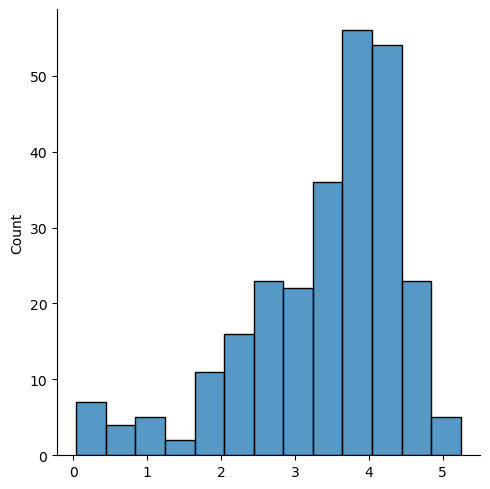

In [545]:
import seaborn as sns
pIC50s = np.array(docking_oracle(mols))
sns.displot(pIC50s[pIC50s > 0.0])